In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "/content/drive/MyDrive/Major Project/data3.json"


def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["lables"])
    return X, y


def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 4th conv layer


    model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
    model.add(keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True)))
    model.add(keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True)))
    model.add(keras.layers.LSTM(32,return_sequences=True))
    model.add(keras.layers.LSTM(32))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256 , activation ='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    # flatten output and feed it into dense layer
    '''model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))'''

    # output layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(15, activation='softmax'))

    return model






    # pick a sample to predict from the test set
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
print(X_test.shape)



(3747, 130, 13, 1)


(130, 13, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                           

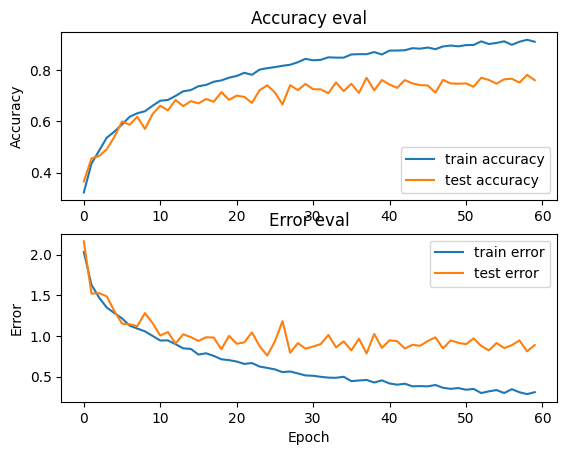

281/281 - 2s - loss: 0.2336 - accuracy: 0.9268 - 2s/epoch - 6ms/step

Train accuracy: 0.9268156886100769
118/118 - 1s - loss: 0.7999 - accuracy: 0.7788 - 755ms/epoch - 6ms/step

Test accuracy: 77.8756320476532


In [ ]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    print(input_shape)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=60)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
    print('\nTrain accuracy:', train_acc)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc*100)


In [ ]:
def predict(model, X, y):

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [ ]:
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 2s 2s/step
Target: 14, Predicted label: [14]


In [ ]:
import random
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 24ms/step
Target: 12, Predicted label: [13]
1/1 [==============================] - 0s 22ms/step
Target: 1, Predicted label: [3]
1/1 [==============================] - 0s 25ms/step
Target: 3, Predicted label: [5]
1/1 [==============================] - 0s 31ms/step
Target: 3, Predicted label: [6]
1/1 [==============================] - 0s 26ms/step
Target: 12, Predicted label: [12]
1/1 [==============================] - 0s 26ms/step
Target: 11, Predicted label: [10]
1/1 [==============================] - 0s 30ms/step
Target: 6, Predicted label: [6]
1/1 [==============================] - 0s 29ms/step
Target: 14, Predicted label: [1]
1/1 [==============================] - 0s 27ms/step
Target: 10, Predicted label: [10]
1/1 [==============================] - 0s 26ms/step
Target: 4, Predicted label: [4]


## Predicting new song

In [ ]:
import librosa
import math

def process_input(audio_file, track_duration):

  SAMPLE_RATE = 22050
  NUM_MFCC = 13
  N_FTT=2048
  HOP_LENGTH=512
  TRACK_DURATION = track_duration # measured in seconds
  SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
  NUM_SEGMENTS = 10

  samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

  signal, sample_rate = librosa.load(audio_file, sr=22050)
  print(signal)
  print(sample_rate)

  all_mfcc = {
      "mfcc": []
  }

  for d in range(10):

    # calculate start and finish sample for current segment
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FTT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T
    all_mfcc["mfcc"].append(mfcc.tolist())


  return all_mfcc

[-4.34335607e-06 -9.73845727e-06 -1.31000725e-05 ... -1.57701834e-07
 -1.48034815e-07 -1.89029379e-08]
22050
1/1 [==============================] - 0s 28ms/step


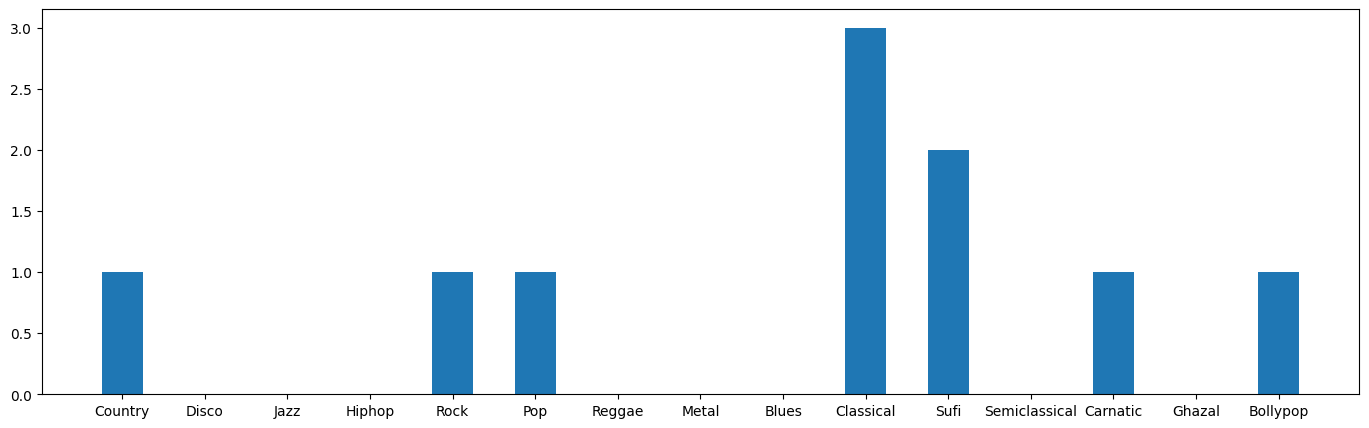

In [ ]:
genre_dict = {0:"country",1:"disco",2:"jazz",3:"hiphop",4:"rock",5:"pop",6:"reggae",7:"metal",8:"blues",9:"classical", 10:"sufi", 11:"semiclassical", 12:"carnatic", 13:"ghazal", 14:"bollypop"}

new_input_mfcc = process_input("/content/drive/MyDrive/Major Project/sample songs/Kun Faaya Kun - Rockstar 128 Kbps.mp3", 30)
new_input_mfcc = np.array(new_input_mfcc["mfcc"])

results = np.zeros(15)
genre_labels = []
for i in range(10):
  indi_input_mfcc = new_input_mfcc[i]
  X_to_predict = indi_input_mfcc[np.newaxis, ..., np.newaxis]
  prediction = model.predict(X_to_predict)
  predicted_index = np.argmax(prediction, axis=1)
  results[int(predicted_index)]+=1

genre_labels = ["Country", "Disco", "Jazz", "Hiphop", "Rock", "Pop","Reggae", "Metal", "Blues","Classical","Sufi","Semiclassical","Carnatic","Ghazal","Bollypop"]

plt.figure(figsize=(17, 5))
plt.bar(genre_labels, results, 0.5)
plt.show()


#X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
#prediction = model.predict(X_to_predict)

# get index with max value
#predicted_index = np.argmax(prediction, axis=1)

#print("Predicted Genre:", genre_dict[int(predicted_index)])
